## Data

In [17]:
from notebooks.text_processing import generate_corpus_df, add_sectarian_label, convert_df_to_by_book
import pandas as pd

from notebooks.utils import generate_composition_to_book
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = generate_corpus_df()
df = add_sectarian_label(df)

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


100%|██████████| 52895/52895 [00:05<00:00, 10192.32it/s]
[04-19 18:18:34] {/Users/yonatanlou/dev/QumranNLP/notebooks/text_processing.py:60} INFO - Generated 997 unique books
/Users/yonatanlou/dev/QumranNLP/notebooks/utils.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["book_pasuk"] = df_filtered["book"] + " " + df_filtered["pasuk"]
[04-19 18:18:35] {/Users/yonatanlou/dev/QumranNLP/notebooks/text_processing.py:62} INFO - Removed 387 books that are smaller than 100 words per book


In [3]:
null_lines = (df["text"].isna())
print(f"remove {(null_lines.sum())} null lines")
df = df[~null_lines]
df_by_book = convert_df_to_by_book(df)
composition_to_book = generate_composition_to_book()
df_by_book_by_comp =pd.merge(df_by_book, composition_to_book, on="book", how="inner")
df_by_book_by_comp

remove 16 null lines


,book,text,label,section,composition
0,11Q1,וסמכ ידו על ראש השעיר ושחט אתו ╱ במקומ אשר י...,bib,NaN,Lev
1,11Q12,הודענו בצאתנו לפני יהוה אלוהינו את כול החטאו...,nonbib,non_sectarian_texts,Book_of_Jubilees
2,11Q19,כי נורא הוא אשר אני עושה עמכה . הנני גורש מ...,nonbib,unknown,Temple Scroll
3,11Q2,ואתן אתם לאהרן הכהן ולבניו לחק עולם מאת בני ╱ ...,bib,NaN,Lev
4,11Q20,והקריבו על המזבח לכול יום ויום פר בן...,nonbib,unknown,Temple Scroll
...,...,...,...,...,...
355,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Nah
356,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Obad
357,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Zech
358,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Zeph


## Topic modeling

In [4]:
import pandas as pd
from gensim import corpora, models
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk

# Make sure to download NLTK stopwords if not already done
nltk.download('stopwords')

# Step 1: Prepare Data
# Tokenize and remove stopwords
stop_words = set(stopwords.words('hebrew'))

def get_top_topics(lda_model, book,n_words=10):
    
    topic_words = pd.DataFrame({})
    
    for i, topic in enumerate(lda_model.get_topics()):
        top_feature_ids = topic.argsort()[-n_words:][::-1]
        feature_values = topic[top_feature_ids]
        words = [dictionary[id] for id in top_feature_ids]
        topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
        topic_words = pd.concat([topic_words, topic_df], ignore_index=True)
    topic_words["book"] = book
    
    return topic_words




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:

# Step 1: Prepare Data
# Tokenize and remove stopwords
stop_words = set(stopwords.words('hebrew'))
texts = [
    [word for word in simple_preprocess(str(doc)) if word not in stop_words]
    for doc in df_by_book['text']
]
data_ready=texts

id2word = corpora.Dictionary(texts)
# Convert dictionary to a bag of words corpus
corpus = [id2word.doc2bow(text) for text in texts]

# Step 3: LDA Model Training
# Number of topics
num_topics = 6
# Build LDA model
lda_model = models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [6]:

ldamodel =lda_model
texts = data_ready
# Init output
df_topic_sents_keywords = pd.DataFrame()

# Get main topic in each document
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            # df_topic_sents_keywords = df_topic_sents_keywords.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], ignore_index=True)

        else:
            break
df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

# Add original text to the end of the output
contents = pd.Series(texts)
df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)




# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.7126,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל,...","[וסמכ, ידו, ראש, השעיר, ושחט, אתו, במקומ, ישחט..."
1,1,1,0.7227,"די, אמין, קנין, דן, תרין, תרעא, שנין, ואמר, לה...","[תולעה, ומא, אפו, העמי, לשאול, תנחתון, כחדה, ע..."
2,2,2,0.3709,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל,...","[וה, כב, הא, דם, סוכות, לם, יך, שבעים, למים, א..."
3,3,3,0.4506,"יהוה, ולא, ישראל, לך, ויאמר, אלהיך, אמר, הארץ,...","[הודענו, בצאתנו, יהוה, אלוהינו, כול, החטאות, י..."
4,4,2,0.5100,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל,...","[שון, מושה, כיא, ואשר, אמר, בשנת, היובל, הזואת..."
5,5,2,0.8047,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל,...","[בום, ליו, צמח, דויד, ישעיהו, הנביא, ונוקפו, ס..."
6,6,4,0.6584,"כול, לוא, ואין, רוח, כיא, כה, צדק, שמים, לעולם...","[ים, האור, סדרותיו, סדרותיו, מבנית, שי, קודש, ..."
7,7,1,0.7311,"די, אמין, קנין, דן, תרין, תרעא, שנין, ואמר, לה...","[ין, סר, ארעי, כו, חתא, רתא, יא, בע, עוב, מר, ..."
8,8,2,0.8162,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל,...","[נורא, עושה, עמכה, הנני, גורש, מפניכה, האמורי,..."
9,9,2,0.7573,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל,...","[ואתן, לאהרן, הכהן, ולבניו, לחק, עולם, מאת, בנ..."


In [8]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)
# sent_topics_sorteddf_mallet["Representative Text"].apply(list).str.join(" ")[0]

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7915,"וא, תה, בר, וב, תו, ומ, הא, הי, מש, לש","[אד, ומ, בר]"
1,1,0.9369,"די, אמין, קנין, דן, תרין, תרעא, שנין, ואמר, להון, ולא","[מלי, כתבא, די, אמר, מיכאל, למלאכיא, חזוא, די, אמר, די, גדודי, נורא, תמה, השכחת, תמה, חזית, תשעה..."
2,2,0.9989,"איש, ישראל, בני, כול, בו, ואם, דויד, לוא, ואל, יונה","[באחד, בידעיה, בשנים, עשר, בוא, בשנים, באביה, בחמישה, ועשרים, בשמיני, ודוקה, בשלושה, במימין, בשנ..."
3,3,0.9974,"יהוה, ולא, ישראל, לך, ויאמר, אלהיך, אמר, הארץ, וכל, היום","[וידבר, יהוה, משה, לאמר, קדש, בכור, פטר, רחם, בבני, ישראל, באדם, ובבהמה, ויאמר, משה, העם, זכור, ..."
4,4,0.9324,"כול, לוא, ואין, רוח, כיא, כה, צדק, שמים, לעולם, עולם","[אלים, אתחשב, ומעוני, בעדת, קודש, לבוז, נחשב, בי, ומי, נבזה, כמוני, ומי, כמוני, חדל, אישים, ומי,..."
5,5,0.7528,"גוג, דדיך, הלו, מיין, שאהבה, בנתי, עלמות, שמוני, השירים, ששזפתני","[וישעון, לך, אוגו, יהונתן, הצבאים, גנבו, גנבו, המזלגות, גוג, וםגוג, בית, בטפם, נתונים, תסובבון, ..."


In [9]:
df_dominant_topic.groupby("Dominant_Topic")["Document_No"].count()
# Dominant_Topic
# 0    198
# 1     18
# 2    256
# 3     49
# 4     90
# 5      2

Dominant_Topic
0     36
1     84
2    128
3    210
4    153
5      2
Name: Document_No, dtype: int64

In [10]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for n_topics in tqdm(range(start, limit, step)):
        model = models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
rerun = False
if rerun:
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=4)
    
    # Show graph
    limit=40; start=2; step=4;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

#Seems like 6 topics is the best

In [11]:
by_book = df.groupby("book")["text"].apply(list).str.join(" ")
df_by_book = pd.merge(by_book, df[["book","label","section"]], on="book", how="inner").drop_duplicates()
df_dominant_topic["book"]= df_by_book.reset_index()["book"]
df_by_book = pd.merge(df_dominant_topic[["Dominant_Topic","book"]], df_by_book, on="book")


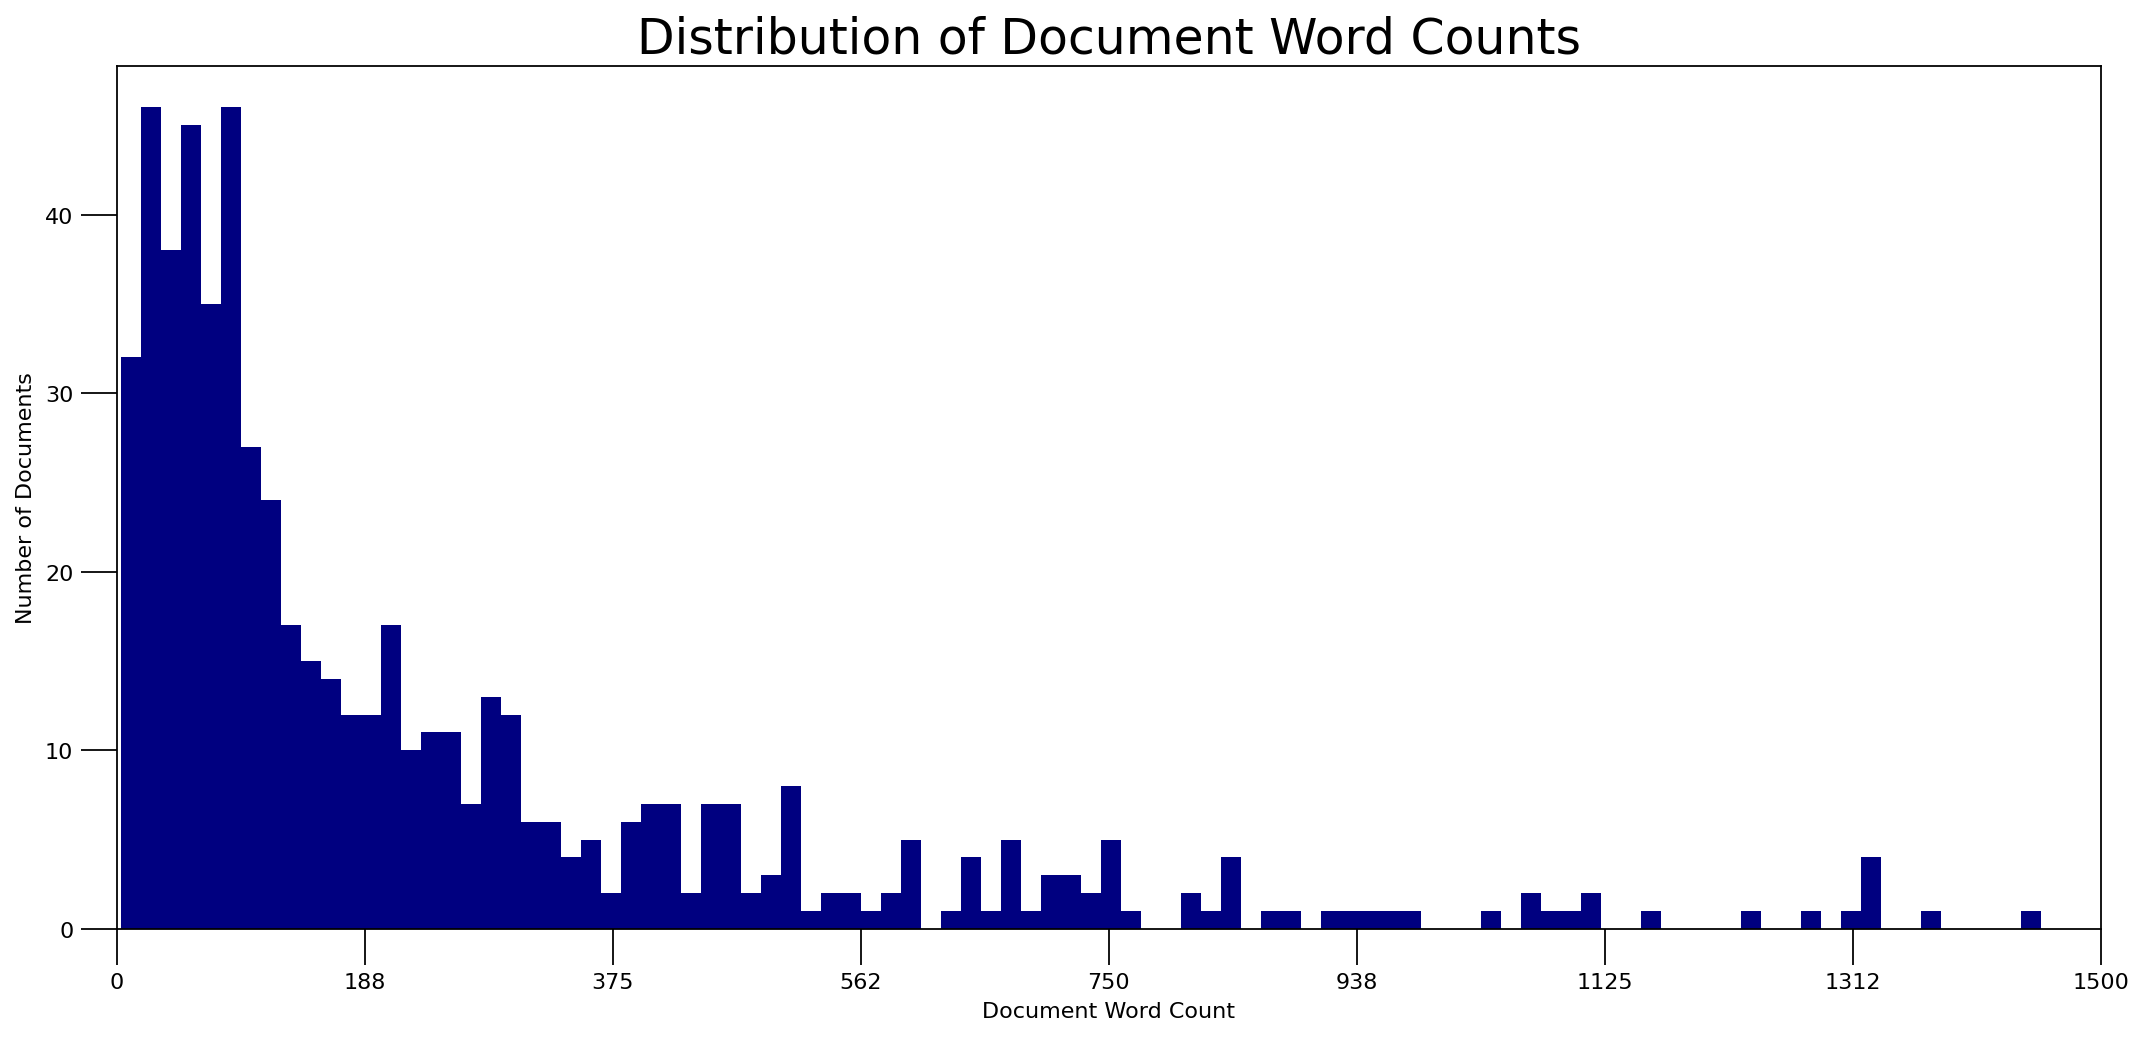

In [15]:
import numpy as np
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
# plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

6it [00:04,  1.23it/s]


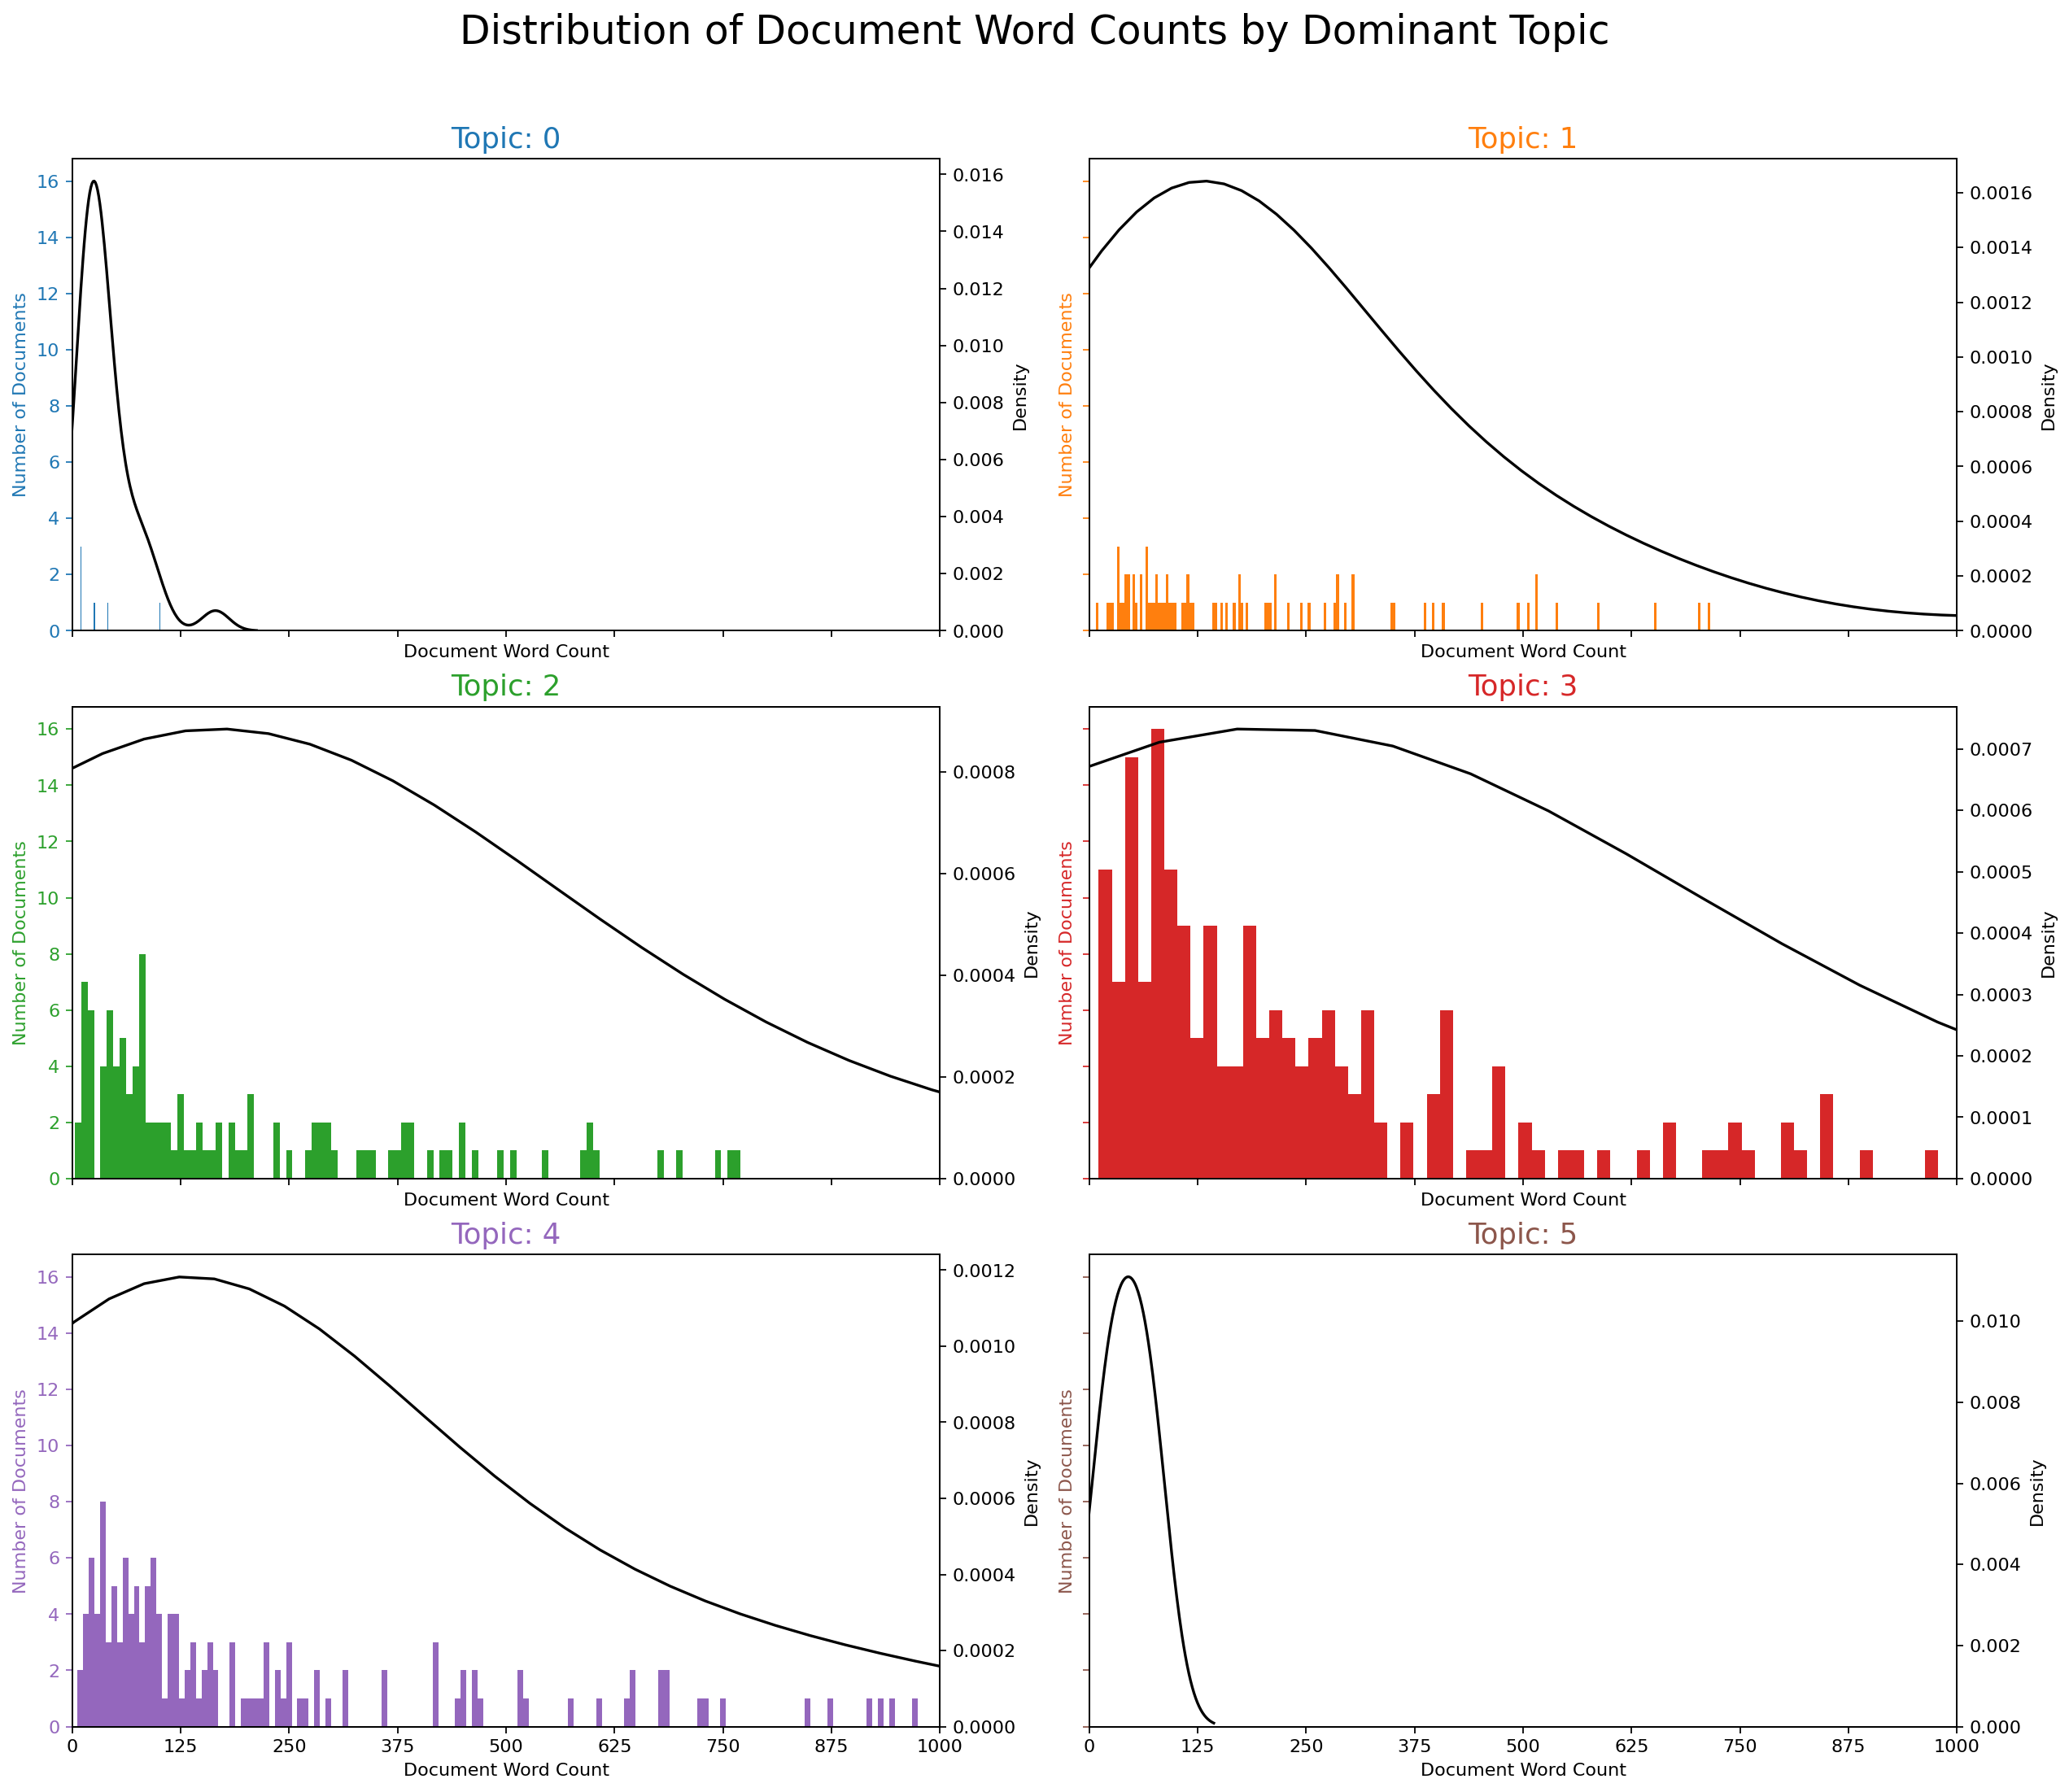

In [18]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(num_topics//2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in tqdm(enumerate(axes.flatten())):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_77668/3738718611.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i[::-1] for i in df.loc[df.topic_id==i, 'word']], rotation=30, horizontalalignment= 'right')
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_77668/3738718611.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i[::-1] for i in df.loc[df.topic_id==i, 'word']], rotation=30, horizontalalignment= 'right')
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_77668/3738718611.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i[::-1] for i in df.loc[df.topic_id==i, 'word']], rotation=30, horizontalalignment= 'right')
/var/folders/yv/8bscwg

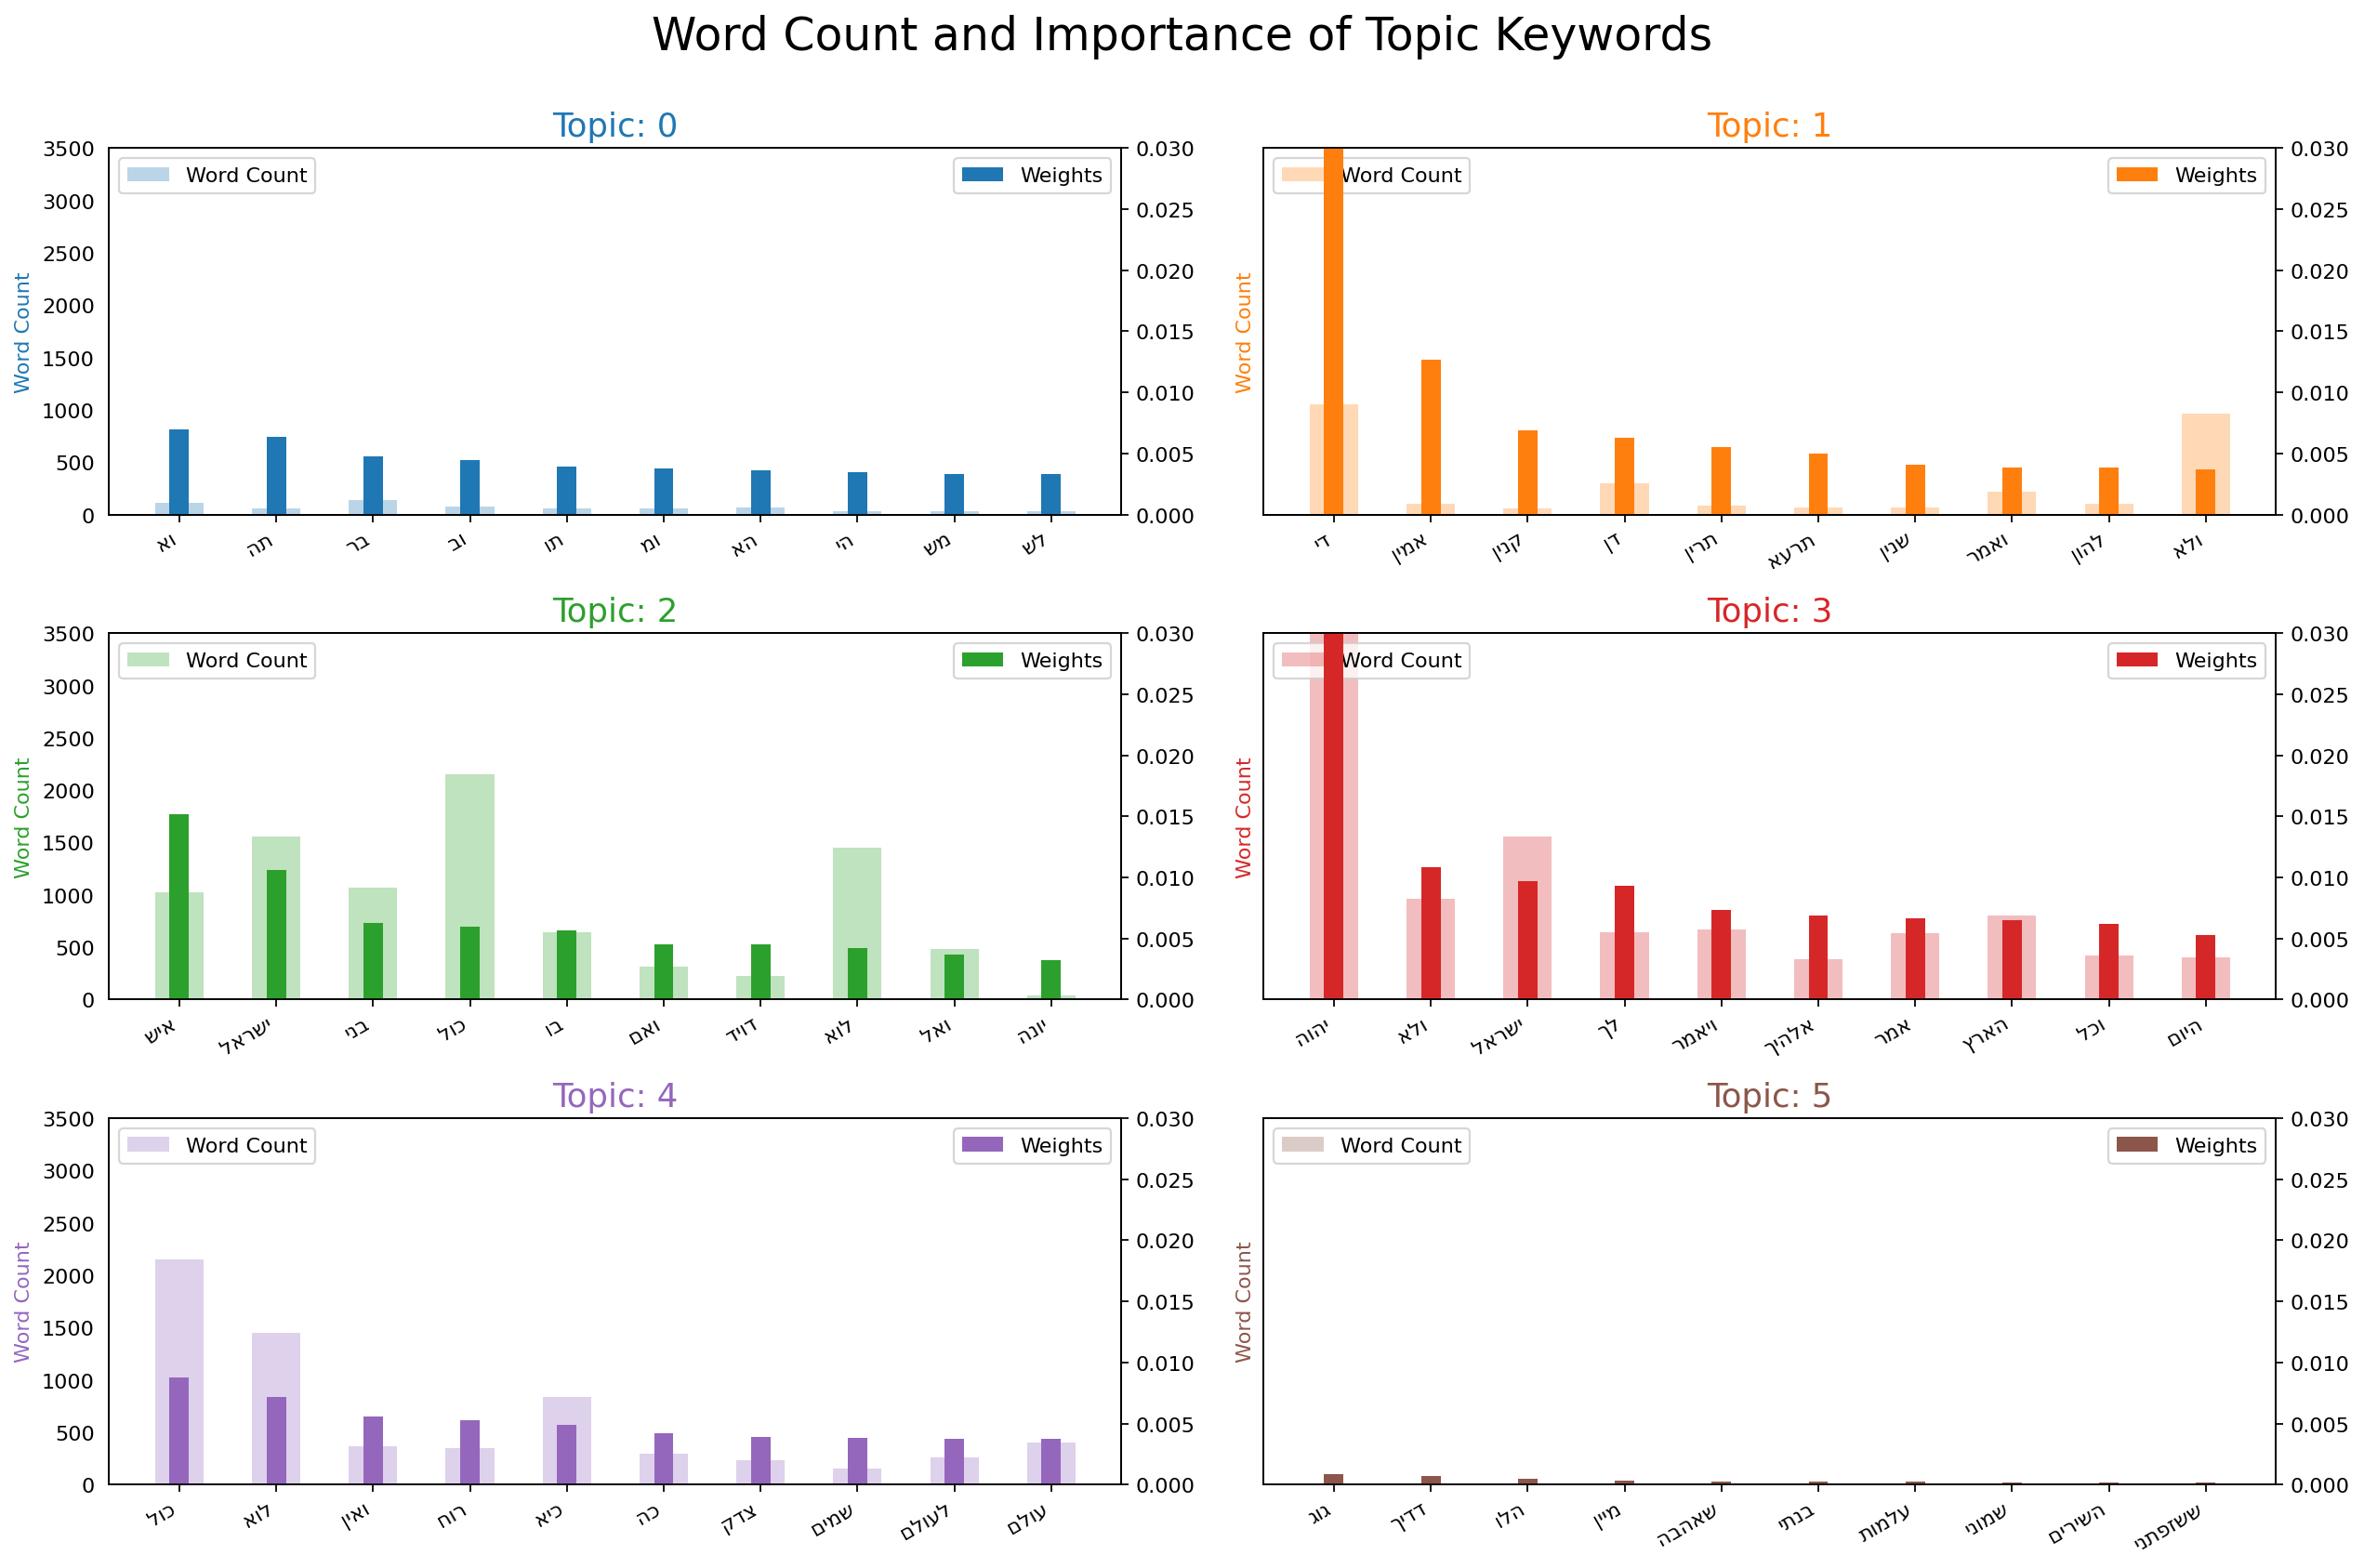

In [20]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(num_topics//2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels([i[::-1] for i in df.loc[df.topic_id==i, 'word']], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


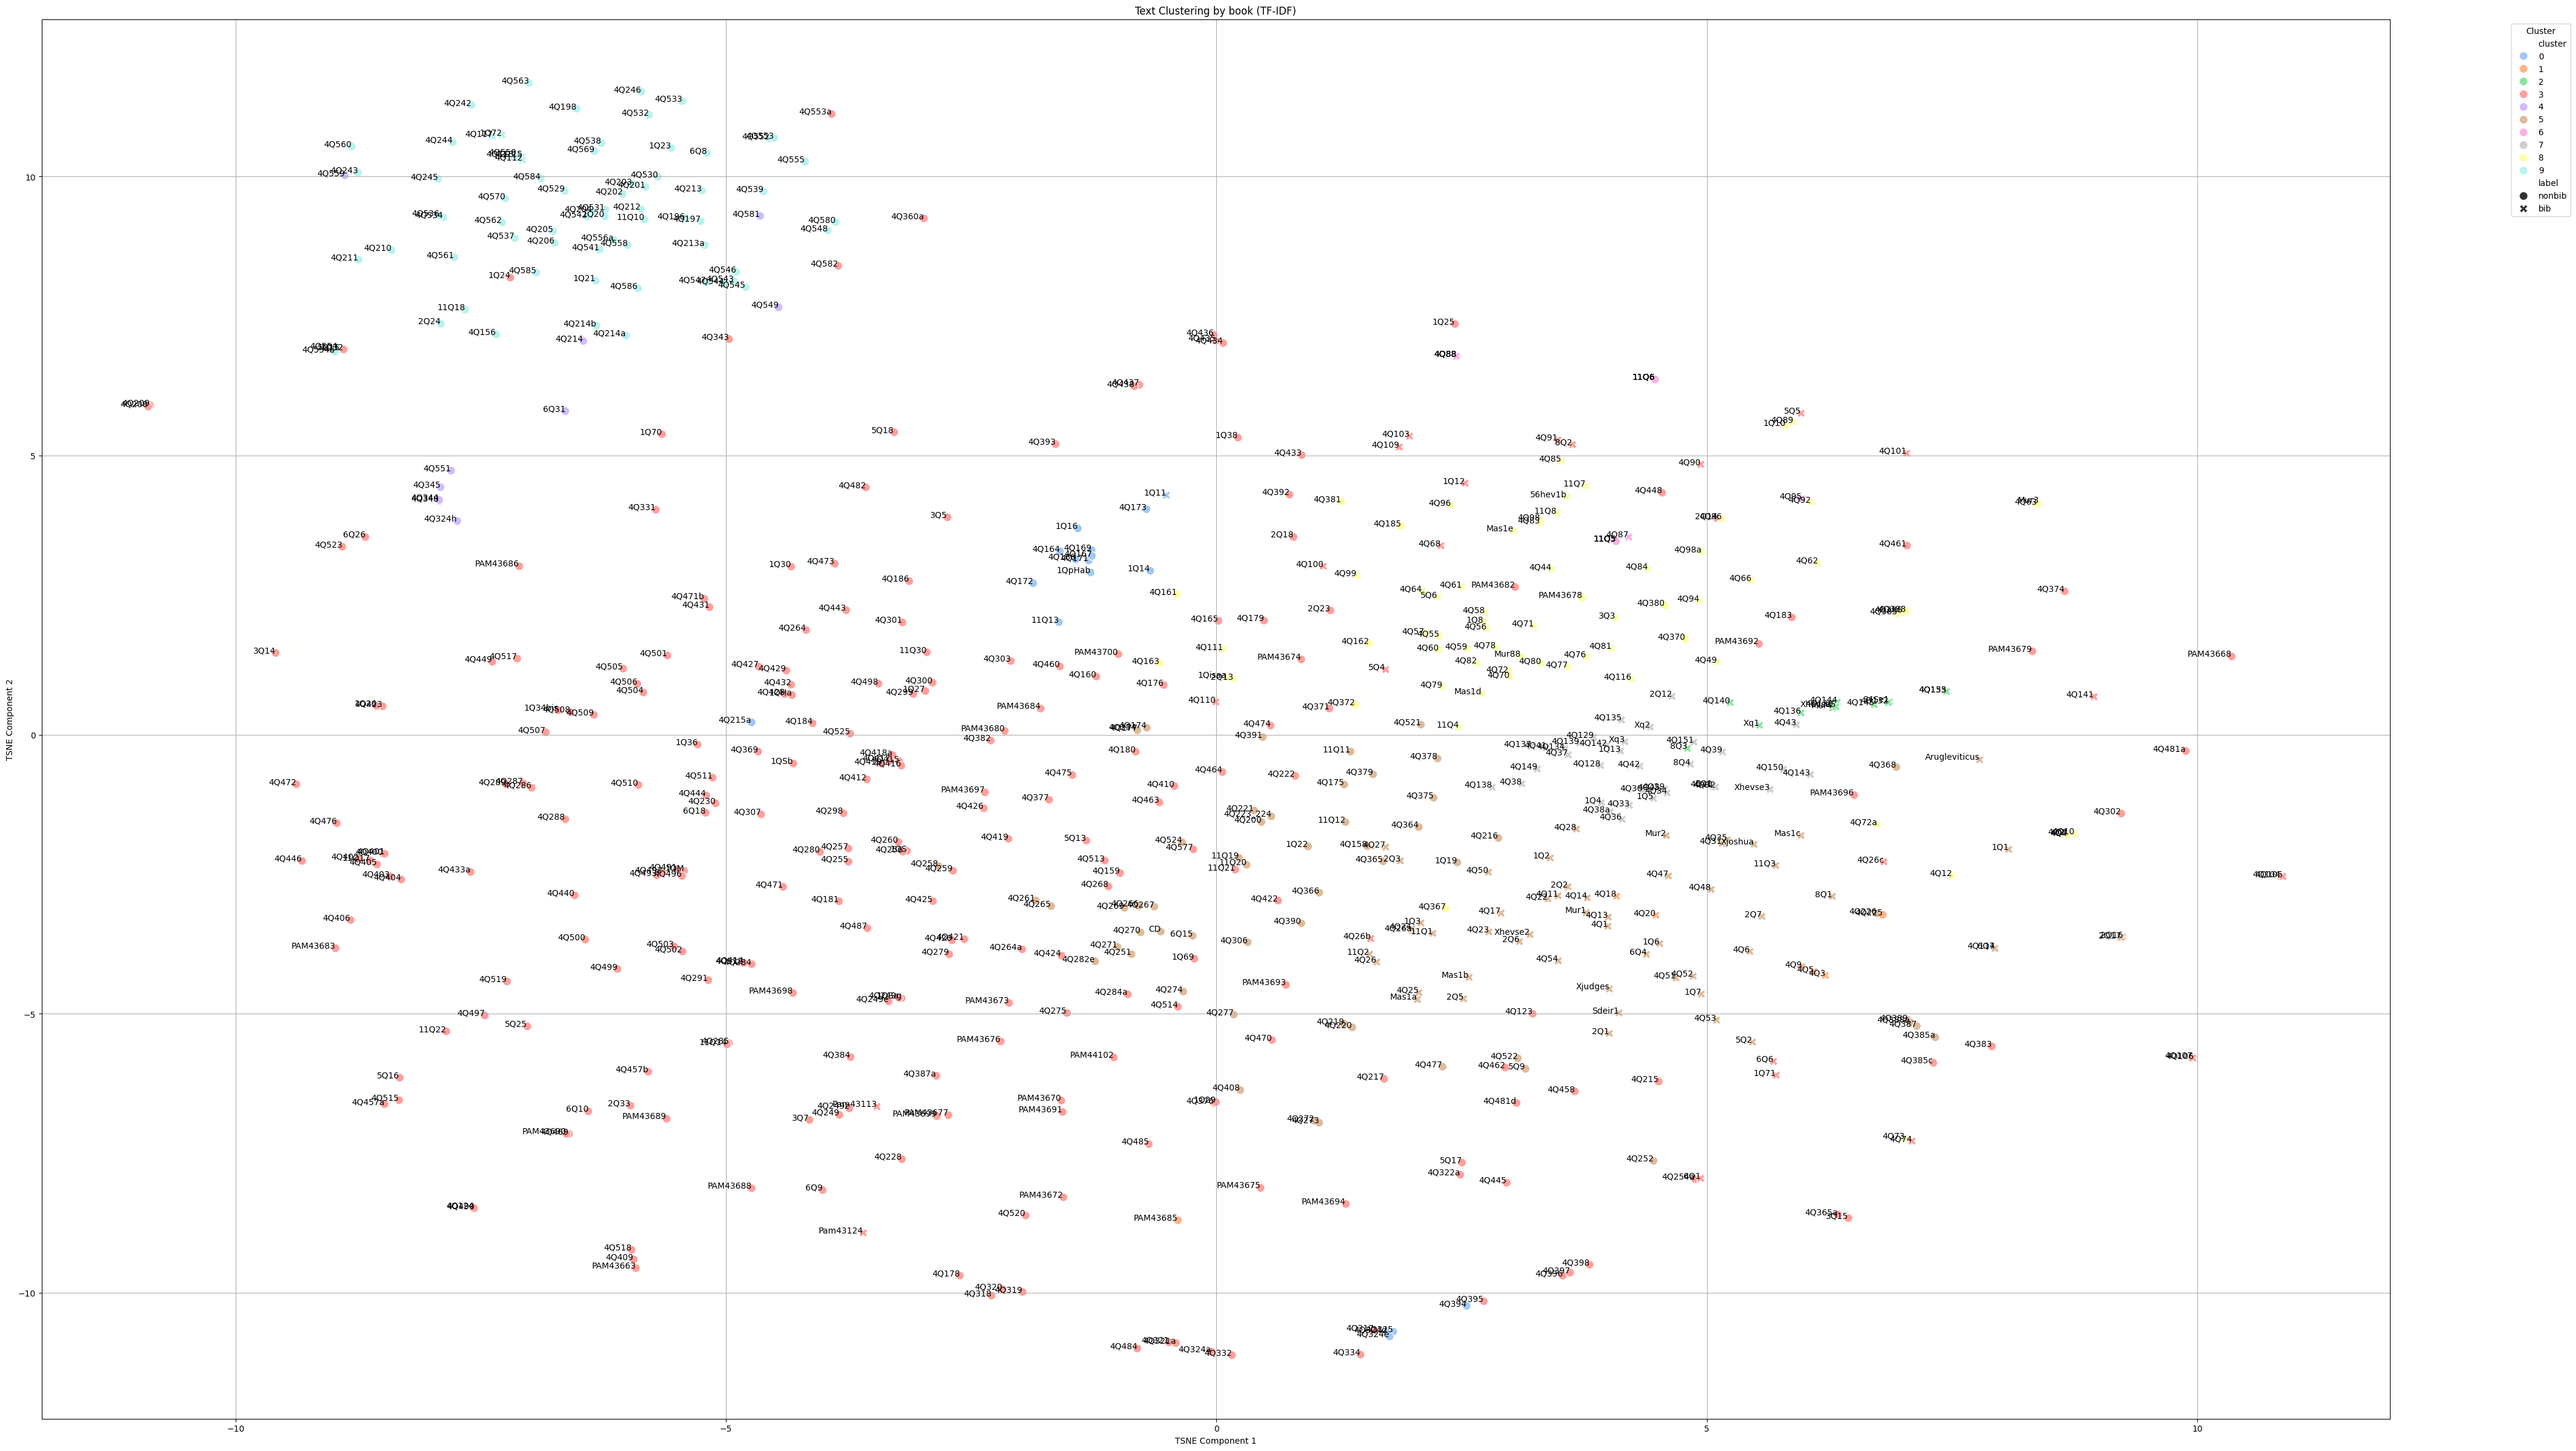

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Step 1: Prepare Data
df_sampled = df_by_book.sample(frac=1, random_state=42)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_sampled['text'])

# Step 2: Clustering
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X)
df_sampled['cluster'] = clusters

# Visualization
tsne = TSNE(n_components=2, random_state=0, perplexity=100)
components = tsne.fit_transform(X.toarray())

# Plot using seaborn for the scatter plot
plt.figure(figsize=(50, 30))
scatter = sns.scatterplot(x=components[:,0], y=components[:,1], hue=df_sampled['cluster'], palette='pastel', style=df_sampled['label'], s=100)

# Adding text labels
for i, text in enumerate(df_sampled['book']):
    plt.text(components[i, 0], components[i, 1], text, fontdict=dict(color='black', size=10), ha='right')

plt.title('Text Clustering by book (TF-IDF)')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig("tsne_by_book.png")
plt.show()

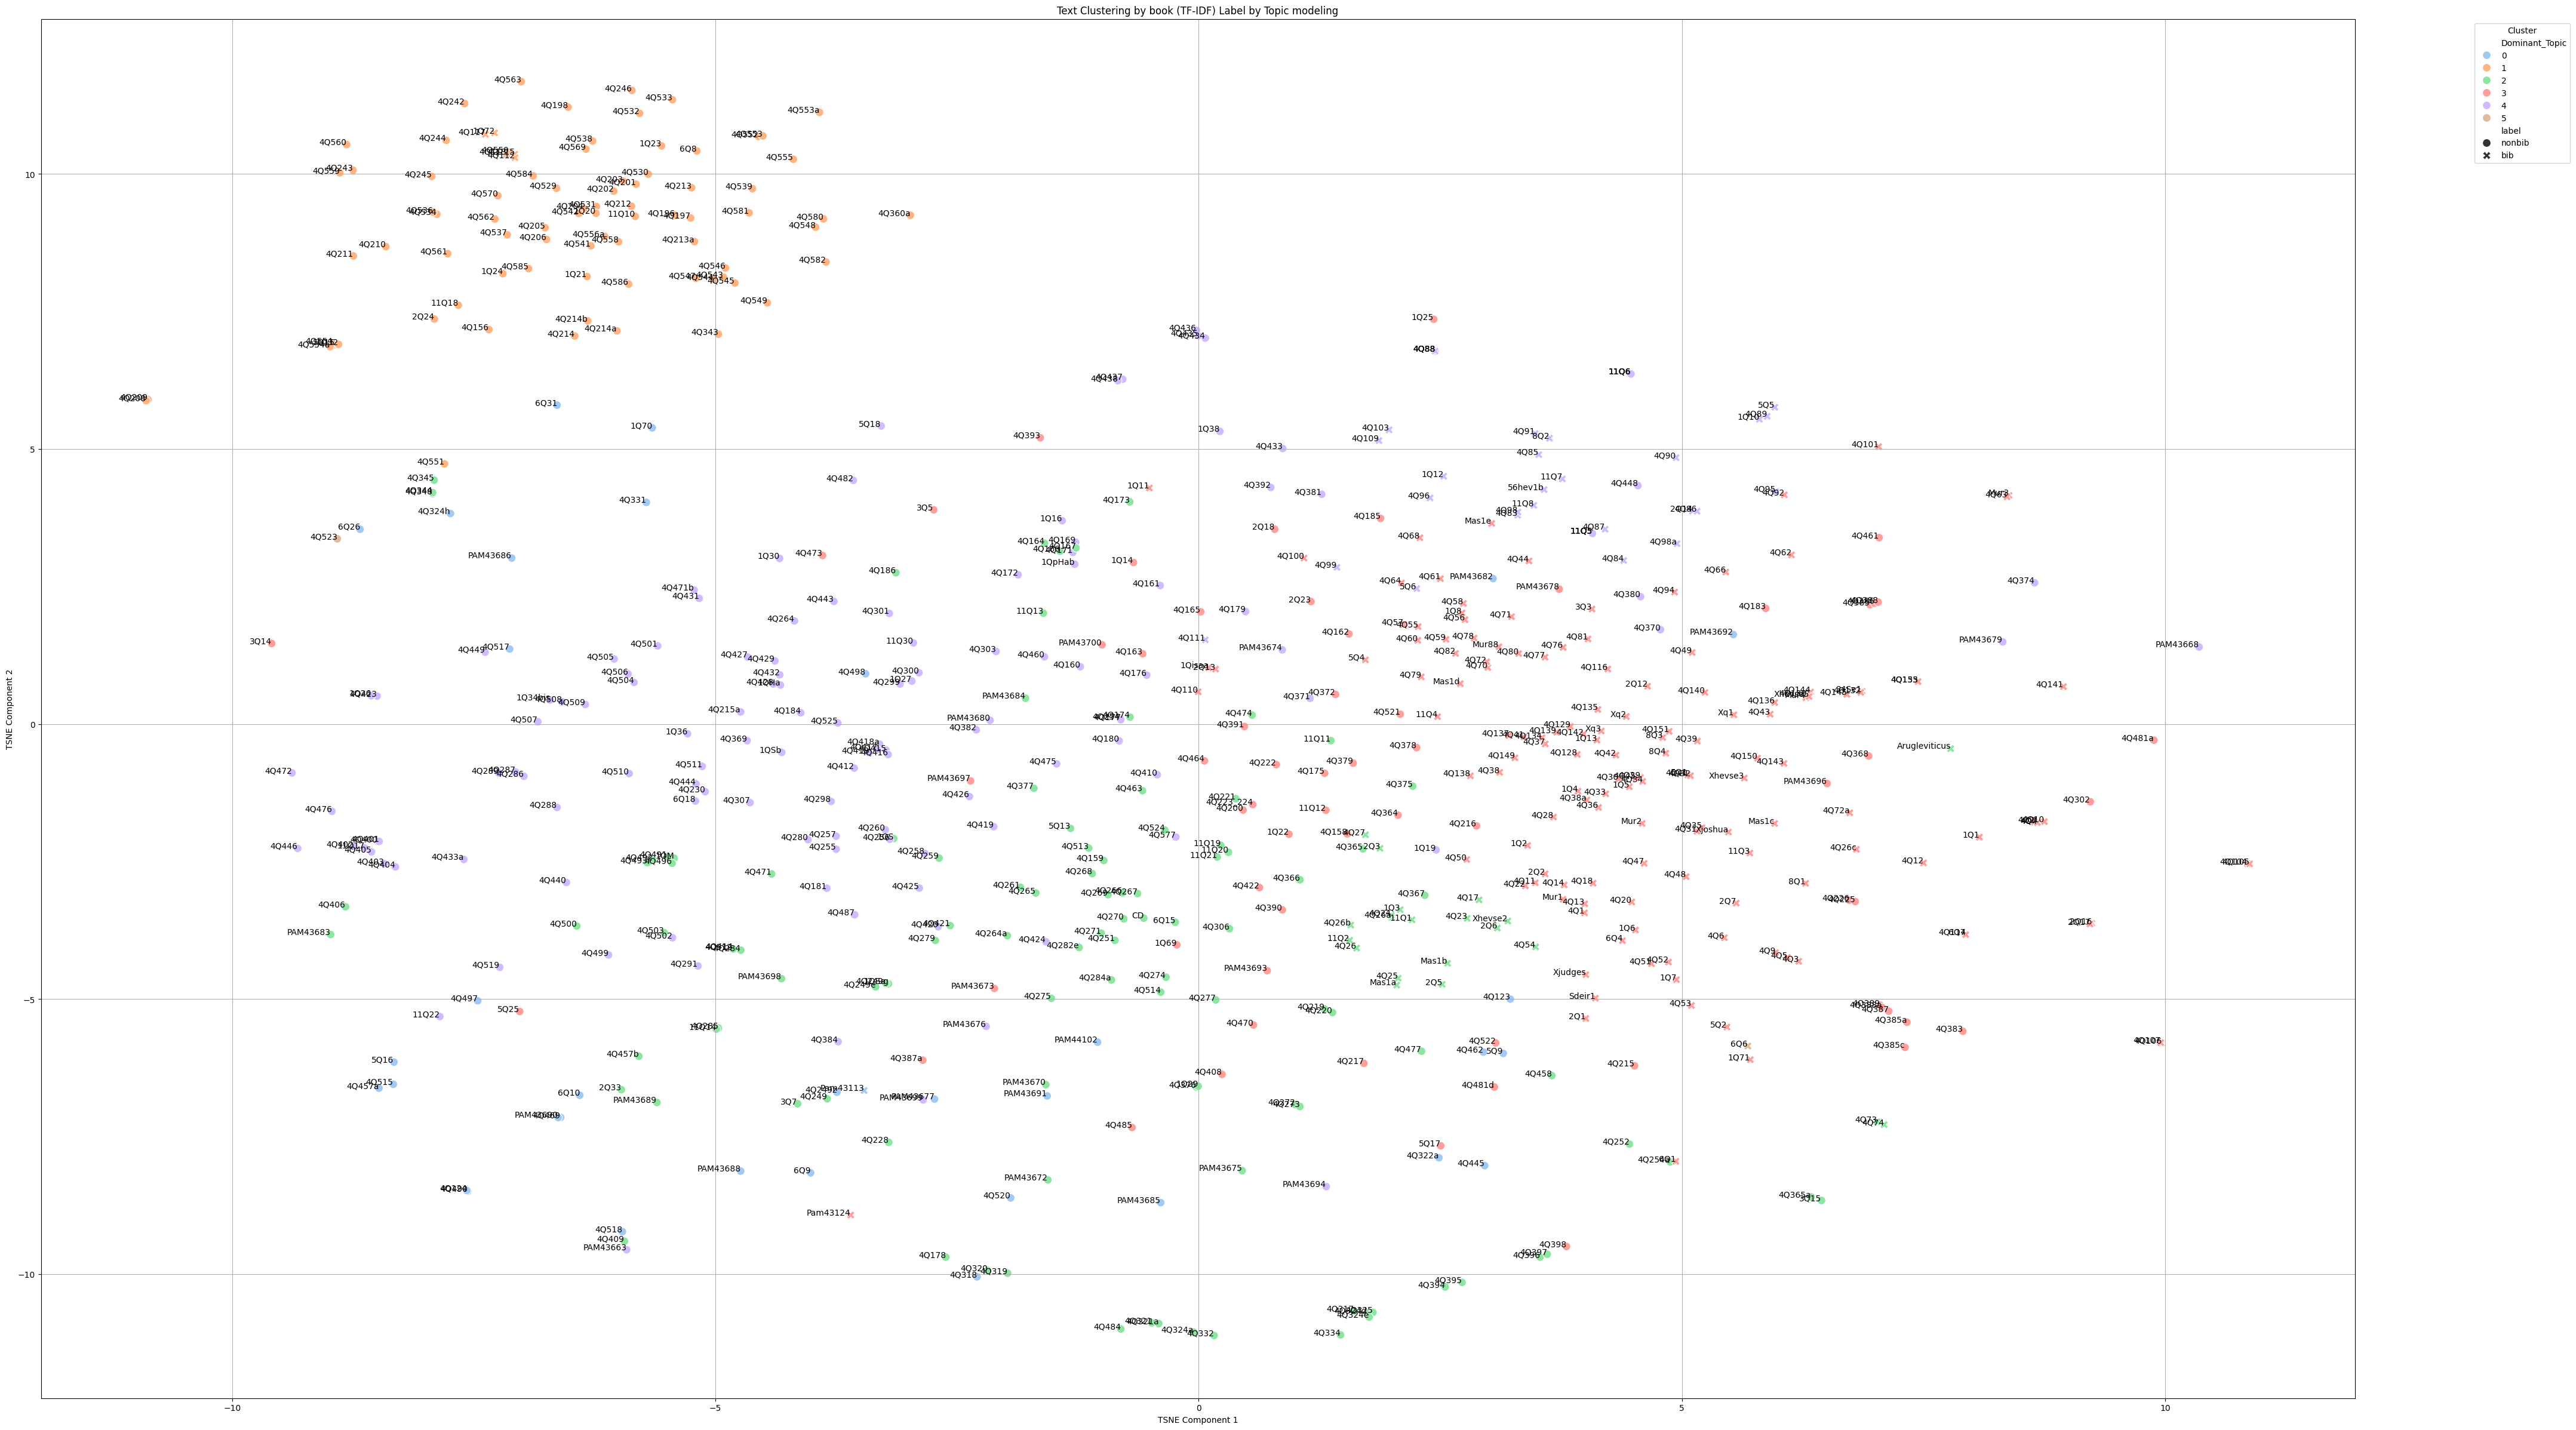

In [24]:

plt.figure(figsize=(50, 30))
scatter = sns.scatterplot(x=components[:,0], y=components[:,1], hue=df_sampled['Dominant_Topic'], palette='pastel', style=df_sampled['label'], s=100)

# Adding text labels
for i, text in enumerate(df_sampled['book']):
    plt.text(components[i, 0], components[i, 1], text, fontdict=dict(color='black', size=10), ha='right')

plt.title('Text Clustering by book (TF-IDF) Label by Topic modeling')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()